# Lecture 5. Ensemble Learning

**Crowd intelligence**

Joaquin Vanschoren

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = False # Set to True for interactive plots
if interactive:
    fig_scale = 0.9
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.3
    plt.rcParams.update(print_config)

## Ensemble learning
* If different models make different mistakes, can we simply average the predictions?
* Voting Classifier: gives every model a _vote_ on the class label
    * Hard vote: majority class wins (class order breaks ties)
    * Soft vote: sum class probabilities $p_{m,c}$ over $M$ models: $\underset{c}{\operatorname{argmax}} \sum_{m=1}^{M} w_c p_{m,c}$
    * Classes can get different weights $w_c$ (default: $w_c=1$)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Toy data
X, y = make_moons(noise=.2, random_state=18) # carefully picked random state for illustration
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Plot grid
x_lin = np.linspace(X_train[:, 0].min() - .5, X_train[:, 0].max() + .5, 100)
y_lin = np.linspace(X_train[:, 1].min() - .5, X_train[:, 1].max() + .5, 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
models = [LogisticRegression(C=100),
          DecisionTreeClassifier(max_depth=3, random_state=0),
          KNeighborsClassifier(n_neighbors=1),
          KNeighborsClassifier(n_neighbors=30)]

@interact
def combine_voters(model1=models, model2=models):
    # Voting Classifier and components
    voting = VotingClassifier([('model1', model1),('model2', model2)],voting='soft')
    voting.fit(X_train, y_train)

    # transform produces individual probabilities
    y_probs =  voting.transform(X_grid)

    fig, axes = plt.subplots(1, 3, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(11*fig_scale, 3*fig_scale))
    scores = [voting.estimators_[0].score(X_test, y_test),
             voting.estimators_[1].score(X_test, y_test),
             voting.score(X_test, y_test)]
    titles = [model1.__class__.__name__, model2.__class__.__name__, 'VotingClassifier']
    for prob, score, title, ax in zip([y_probs[:, 1], y_probs[:, 3], y_probs[:, 1::2].sum(axis=1)], scores, titles, axes.ravel()):
        ax.contourf(x_grid, y_grid, prob.reshape(x_grid.shape), alpha=.4, cmap='bwr')
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=7*fig_scale)
        ax.set_title(title + f" \n acc={score:.2f}", pad=0)

interactive(children=(Dropdown(description='model1', options=(LogisticRegression(C=100), DecisionTreeClassifie…

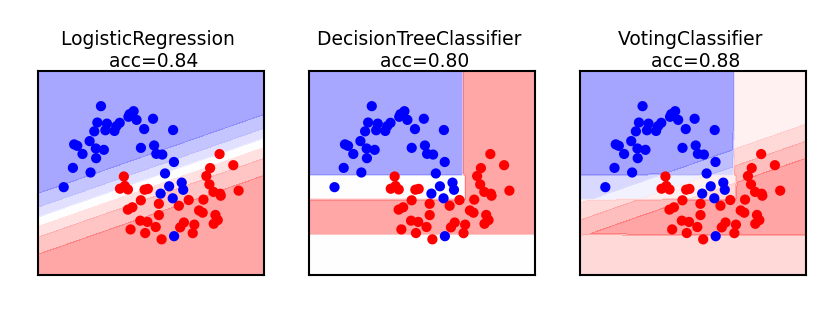

In [3]:
if not interactive:
    combine_voters(models[0],models[1])

* Why does this work?
    * Different models may be good at different 'parts' of data (even if they underfit)
    * Individual mistakes can be 'averaged out' (especially if models overfit)
* Which models should be combined?
* Bias-variance analysis teaches us that we have two options:
    * If model underfits (high bias, low variance): combine with other low-variance models
        * Need to be different: 'experts' on different parts of the data
        * Bias reduction. Can be done with **_Boosting_**
    * If model overfits (low bias, high variance): combine with other low-bias models
        * Need to be different: individual mistakes must be different
        * Variance reduction. Can be done with **_Bagging_**
* Models must be uncorrelated but good enough (otherwise the ensemble is worse)
* We can also _learn_ how to combine the predictions of different models: **_Stacking_**

## Decision trees (recap)
* Representation: Tree that splits data points into leaves based on tests
* Evaluation (loss): Heuristic for purity of leaves (Gini index, entropy,...)
* Optimization: Recursive, heuristic greedy search (Hunt's algorithm)
    * Consider all splits (thresholds) between adjacent data points, for every feature
    * Choose the one that yields the purest leafs, repeat

In [4]:
import graphviz

@interact
def plot_depth(depth=(1,5,1)):
    X, y = make_moons(noise=.2, random_state=18) # carefully picked random state for illustration
    fig, ax = plt.subplots(1, 2, figsize=(12*fig_scale, 4*fig_scale),
                           subplot_kw={'xticks': (), 'yticks': ()})

    tree = mglearn.plots.plot_tree(X, y, max_depth=depth)
    ax[0].imshow(mglearn.plots.tree_image(tree))
    ax[0].set_axis_off()

interactive(children=(IntSlider(value=3, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

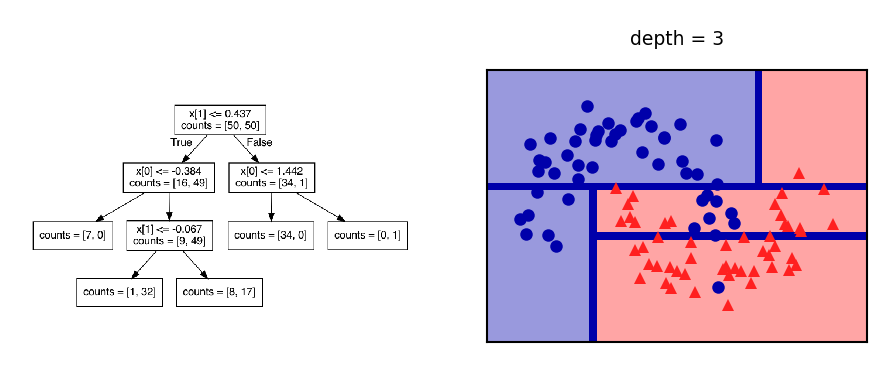

In [5]:
if not interactive:
    plot_depth(depth=3)

### Evaluation (loss function for classification)
* Every leaf predicts a class probability $\hat{p}_c$ = the relative frequency of class $c$
* Leaf impurity measures (splitting criteria) for $L$ leafs, leaf $l$ has data $X_l$:
    - Gini-Index: $Gini(X_{l}) = \sum_{c\neq c'} \hat{p}_c \hat{p}_{c'}$
    - Entropy (more expensive): $E(X_{l}) = -\sum_{c\neq c'} \hat{p}_c \log_{2}\hat{p}_c$
    - Best split maximizes _information gain_ (idem for Gini index) $$ Gain(X,X_i) = E(X) - \sum_{l=1}^L \frac{|X_{i=l}|}{|X_{i}|} E(X_{i=l}) $$

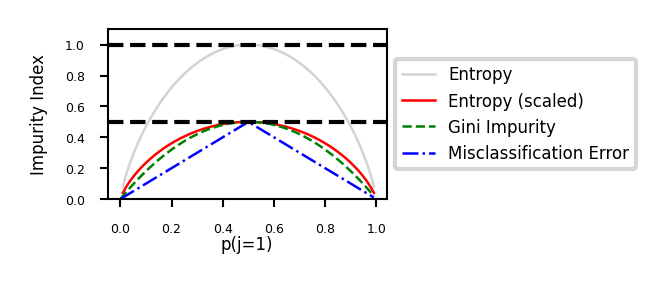

In [6]:
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure(figsize=(5*fig_scale, 2.5*fig_scale))
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=2*fig_scale, color=c)

ax.legend(loc='upper left', ncol=1, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)',labelpad=0)
plt.ylabel('Impurity Index')
plt.show()

### Regression trees
* Every leaf predicts the _mean_ target value $\mu$ of all points in that leaf
* Choose the split that minimizes squared error of the leaves: $\sum_{x_{i} \in L} (y_i - \mu)^2$
* Yields non-smooth step-wise predictions, cannot extrapolate

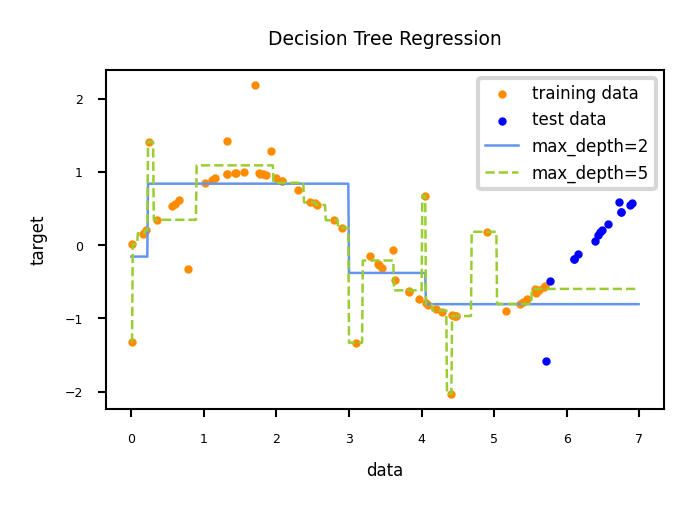

In [7]:
from sklearn.tree import DecisionTreeRegressor

def plot_decision_tree_regression(regr_1, regr_2):
    # Create a random dataset
    rng = np.random.RandomState(5)
    X = np.sort(7 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(16))
    split = 65

    # Fit regression model of first 60 points
    regr_1.fit(X[:split], y[:split])
    regr_2.fit(X[:split], y[:split])

    # Predict
    X_test = np.arange(0.0, 7.0, 0.01)[:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Plot the results
    plt.figure(figsize=(8*fig_scale,5*fig_scale))
    plt.scatter(X[:split], y[:split], c="darkorange", label="training data")
    plt.scatter(X[split:], y[split:], c="blue", label="test data")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2*fig_scale)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2*fig_scale)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

plot_decision_tree_regression(regr_1,regr_2)

### Impurity/Entropy-based feature importance
* We can measure the importance of features (to the model) based on 
    - Which features we split on
    - How high up in the tree we split on them (first splits ar emore important)

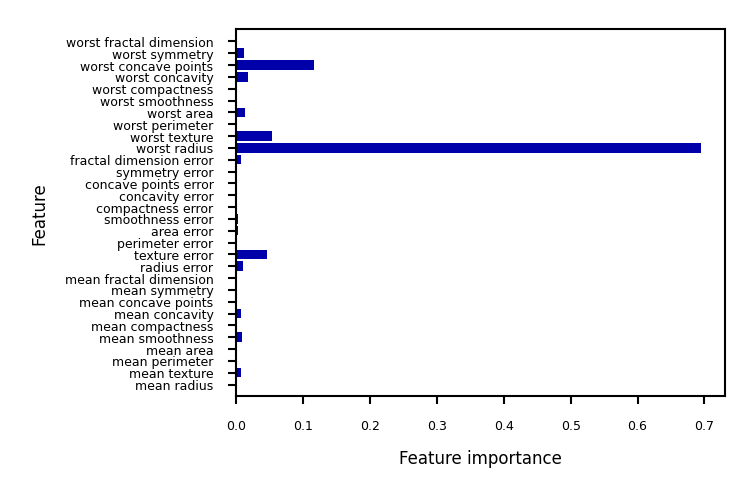

In [8]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0).fit(Xc_train, yc_train)

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_cancer(tree)

### Under- and overfitting
* We can easily control the (maximum) depth of the trees as a hyperparameter
* Bias-variance analysis:
    * Shallow trees have high bias but very low variance (underfitting)
    * Deep trees have high variance but low bias (overfitting)
* Because we can easily control their complexity, they are ideal for ensembling
    * Deep trees: keep low bias, reduce variance with **_Bagging_**
    * Shallow trees: keep low variance, reduce bias with **_Boosting_**

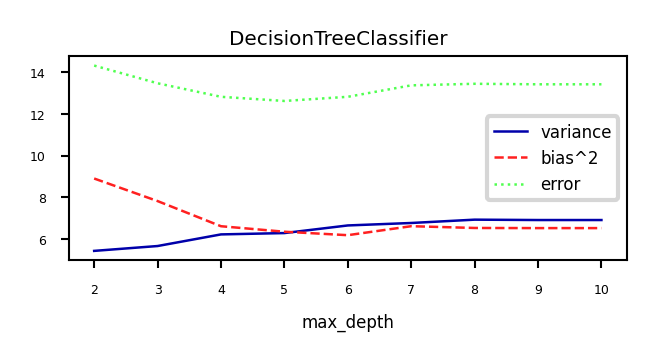

In [9]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

def plot_bias_variance(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    max_depth= range(2,11)

    for i in max_depth:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,max_depth=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(8*fig_scale,3*fig_scale))
    plt.suptitle(clf.__class__.__name__)
    plt.plot(max_depth, var_scores,label ="variance", lw=2*fig_scale )
    plt.plot(max_depth, np.square(bias_scores),label ="bias^2", lw=2*fig_scale )
    plt.plot(max_depth, err_scores,label ="error", lw=2*fig_scale)
    plt.xlabel("max_depth")
    plt.legend(loc="best")
    plt.show()

dt = DecisionTreeClassifier()
plot_bias_variance(dt, cancer.data, cancer.target)

## Bagging (Bootstrap Aggregating)

* Obtain different models by training the _same_ model on _different training samples_
    * Reduce overfitting by averaging out individual predictions (variance reduction)
* In practice: take $I$ bootstrap samples of your data, train a model on each bootstrap
   * Higher $I$: more models, more smoothing (but slower training and prediction)    
* Base models should be unstable: different training samples yield different models
    * E.g. very deep decision trees, or even randomized decision trees 
    * Deep Neural Networks can also benefit from bagging (deep ensembles)
* Prediction by averaging predictions of base models
    * Soft voting for classification (possibly weighted)
    * Mean value for regression
* Can produce uncertainty estimates as well
    * By combining class probabilities of individual models (or variances for regression) 

### Random Forests
* Uses _randomized trees_ to make models even less correlated (more unstable)
    * At every split, only consider `max_features` features, randomly selected
* Extremely randomized trees: considers 1 random threshold for random set of features (faster)

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

models=[RandomForestClassifier(n_estimators=5, random_state=7, n_jobs=-1),ExtraTreesClassifier(n_estimators=5, random_state=2, n_jobs=-1)]

@interact
def run_forest_run(model=models):
    forest = model.fit(X_train, y_train) 
    fig, axes = plt.subplots(2, 3, figsize=(12*fig_scale, 6*fig_scale))
    for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
        ax.set_title("Tree {}".format(i), pad=0)
        mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

    mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                    alpha=.4)
    axes[-1, -1].set_title(model.__class__.__name__, pad=0)
    axes[-1, -1].set_xticks(())
    axes[-1, -1].set_yticks(())
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, s=10*fig_scale);

interactive(children=(Dropdown(description='model', options=(RandomForestClassifier(n_estimators=5, n_jobs=-1,…

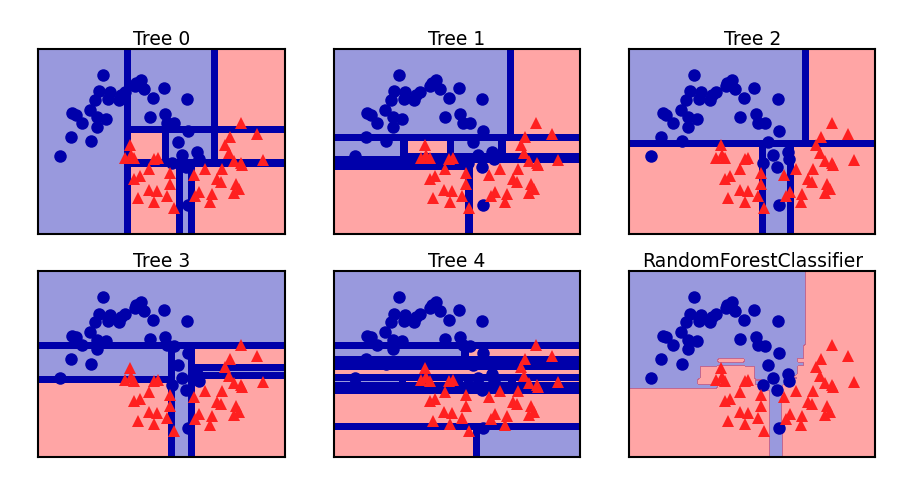

In [11]:
if not interactive:
    run_forest_run(model=models[0])

### Effect on bias and variance
* Increasing the number of models (trees) decreases variance (less overfitting)
* Bias is mostly unaffected, but will increase if the forest becomes too large (oversmoothing)

In [12]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

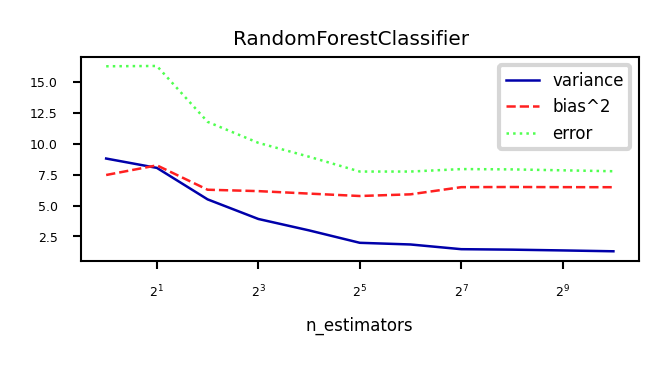

In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
cancer = load_breast_cancer()

def plot_bias_variance_rf(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    n_estimators= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    for i in n_estimators:
        if clf.__class__.__name__ == 'HistGradientBoostingClassifier':
            b,v,e = compute_bias_variance(clf.set_params(random_state=0,max_iter=i),X,y)
        else:
            b,v,e = compute_bias_variance(clf.set_params(random_state=0,n_estimators=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(8*fig_scale,3*fig_scale))
    plt.suptitle(clf.__class__.__name__)
    plt.plot(n_estimators, var_scores,label ="variance", lw=2*fig_scale )
    plt.plot(n_estimators, np.square(bias_scores),label ="bias^2", lw=2*fig_scale )
    plt.plot(n_estimators, err_scores,label ="error", lw=2*fig_scale  )
    plt.xscale('log',base=2)
    plt.xlabel("n_estimators")
    plt.legend(loc="best")
    plt.show()

rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
plot_bias_variance_rf(rf, cancer.data, cancer.target)

#### In practice

* Different implementations can be used. E.g. in scikit-learn:
    * `BaggingClassifier`: Choose your own base model and sampling procedure
    * `RandomForestClassifier`: Default implementation, many options
    * `ExtraTreesClassifier`: Uses extremely randomized trees

* Most important parameters:
    * `n_estimators` (>100, higher is better, but diminishing returns)
        * Will start to underfit (bias error component increases slightly)
    * `max_features`
        * Defaults: $sqrt(p)$ for classification, $log2(p)$ for regression
        * Set smaller to reduce space/time requirements
    * parameters of trees, e.g. `max_depth`, `min_samples_split`,...
        * Prepruning useful to reduce model size, but don't overdo it

* Easy to parallelize (set `n_jobs` to -1)
* Fix `random_state` (bootstrap samples) for reproducibility 

### Out-of-bag error
* RandomForests don't need cross-validation: you can use the out-of-bag (OOB) error
* For each tree grown, about 33% of samples are out-of-bag (OOB)
    - Remember which are OOB samples for every model, do voting over these 
* OOB error estimates are great to speed up model selection 
    - As good as CV estimates, althought slightly pessimistic
* In scikit-learn: `oob_error = 1 - clf.oob_score_`

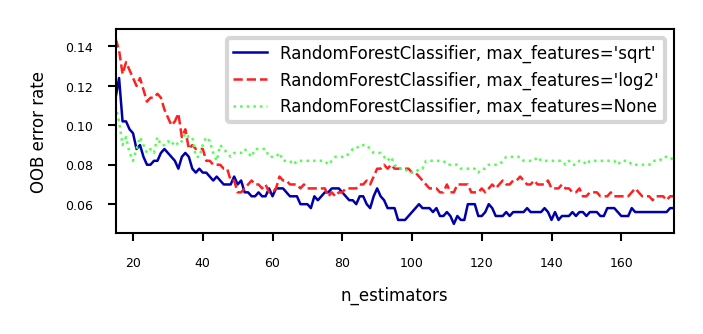

In [14]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", n_jobs=-1,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, n_jobs=-1,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, n_jobs=-1,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(8*fig_scale,3*fig_scale))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label, lw=2*fig_scale)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### Feature importance
* RandomForests provide more reliable feature importances, based on many alternative hypotheses (trees)

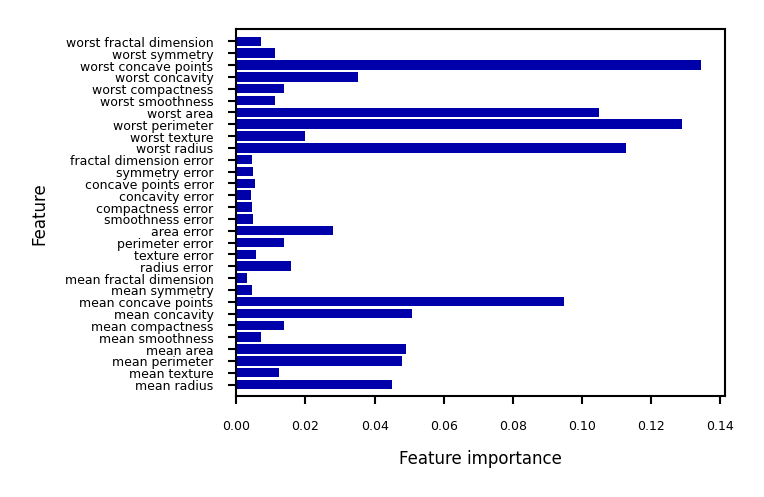

In [15]:
forest = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
forest.fit(Xc_train, yc_train)
plot_feature_importances_cancer(forest)

### Other tips
* Model calibration
    * RandomForests are poorly calibrated. 
    * Calibrate afterwards (e.g. isotonic regression) if you aim to use probabilities
* Warm starting
    * Given an ensemble trained for $I$ iterations, you can simply add more models later
    * You _warm start_ from the existing model instead of re-starting from scratch
    * Can be useful to train models on new, closely related data
        * Not ideal if the data batches change over time (concept drift)
        * Boosting is more robust against this (see later)

### Strength and weaknesses

* RandomForest are among most widely used algorithms:
    * Don't require a lot of tuning
    * Typically very accurate 
    * Handles heterogeneous features well (trees)
    * Implictly selects most relevant features
* Downsides:
    * less interpretable, slower to train (but parallellizable)
    * don't work well on high dimensional sparse data (e.g. text)

## Adaptive Boosting (AdaBoost)

* Obtain different models by _reweighting_ the training data every iteration
    * Reduce underfitting by focusing on the 'hard' training examples
* Increase weights of instances misclassified by the ensemble, and vice versa
* Base models should be simple so that different instance weights lead to different models
    * Underfitting models: decision stumps (or very shallow trees)
    * Each is an 'expert' on some parts of the data
* Additive model: Predictions at iteration $I$ are sum of base model predictions
    * In Adaboost, also the models each get a unique weight $w_i$
$$f_I(\mathbf{x}) = \sum_{i=1}^I w_i g_i(\mathbf{x})$$
* Adaboost minimizes exponential loss. For instance-weighted error $\varepsilon$:
$$\mathcal{L}_{Exp} = \sum_{n=1}^N e^{\varepsilon(f_I(\mathbf{x}))}$$
* By deriving $\frac{\partial \mathcal{L}}{\partial w_i}$ you can find that optimal $w_{i} =  \frac{1}{2}\log(\frac{1-\varepsilon}{\varepsilon})$

### AdaBoost algorithm
* Initialize sample weights: $s_{n,0} = \frac{1}{N}$
* Build a model (e.g. decision stumps) using these sample weights
* Give the _model_ a weight $w_i$ related to its weighted error rate $\varepsilon$
$$w_{i} =  \lambda\log(\frac{1-\varepsilon}{\varepsilon})$$
    * Good trees get more weight than bad trees 
    * Logit function maps error $\varepsilon$ from [0,1] to weight in [-Inf,Inf] (use small minimum error)
    * Learning rate $\lambda$ (shrinkage) decreases impact of individual classifiers
        * Small updates are often better but requires more iterations
* Update the sample weights
    * Increase weight of incorrectly predicted samples:
$s_{n,i+1} = s_{n,i}e^{w_i}$
    * Decrease weight of correctly predicted samples:
$s_{n,i+1} = s_{n,i}e^{-w_i}$
    * Normalize weights to add up to 1
* Repeat for $I$ iterations

### AdaBoost variants
* Discrete Adaboost: error rate $\varepsilon$ is simply the error rate (1-Accuracy)
* Real Adaboost: $\varepsilon$ is based on predicted class probabilities $\hat{p}_c$ (better)
* AdaBoost for regression: $\varepsilon$ is either linear ($|y_i-\hat{y}_i|$), squared ($(y_i-\hat{y}_i)^2$), or exponential loss
* GentleBoost: adds a bound on model weights $w_i$
* LogitBoost: Minimizes logistic loss instead of exponential loss
$$\mathcal{L}_{Logistic} = \sum_{n=1}^N log(1+e^{\varepsilon(f_I(\mathbf{x}))})$$

### Adaboost in action
* Size of the samples represents sample weight
* Background shows the latest tree's predictions

In [16]:
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.preprocessing import normalize

# Code adapted from https://xavierbourretsicotte.github.io/AdaBoost.html
def AdaBoost_scratch(X,y, M=10, learning_rate = 0.5):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [],[],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))
        sample_weight *= np.exp(-estimator_weight * np.invert(incorrect * ((sample_weight > 0) | (estimator_weight < 0))))
        sample_weight /= np.linalg.norm(sample_weight)
        
        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    #print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None, title=None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 1000, edgecolors='none')
    ax.set_xticks(())
    ax.set_yticks(())
    if title:
        ax.set_title(title, pad=1)
    
    # Plot classifier background
    if classifier is not None:
        xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
        
        #Check what methods are available
        if hasattr(classifier, "decision_function"):
            zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        elif hasattr(classifier, "predict_proba"):
            zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        else:
            zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

        # reshape result and plot
        Z = zz.reshape(xx.shape)
    
        ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5, levels=[0,0.5,1])
        #ax.contour(xx, yy, Z, 2, cmap='RdBu', levels=[0,0.5,1])


from sklearn.datasets import make_circles
Xa, ya = make_circles(n_samples=400, noise=0.15, factor=0.5, random_state=1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list = AdaBoost_scratch(Xa, ya, M=60, learning_rate = 0.5)
current_ax = None
weight_scale = 1

@interact
def plot_adaboost(iteration=(0,60,1)):
    if iteration == 0:
        s_weights = (sample_weight_list[0,:] / sample_weight_list[0,:].sum() ) * weight_scale
        plot_decision_boundary(None, Xa, ya, N = 20, scatter_weights =s_weights)
    else:
        s_weights = (sample_weight_list[iteration,:] / sample_weight_list[iteration,:].sum() ) * weight_scale
        title = "Base model {}, error: {:.2f}, weight: {:.2f}".format(
            iteration,estimator_error_list[iteration-1],estimator_weight_list[iteration-1])
        plot_decision_boundary(estimator_list[iteration-1], Xa, ya, N = 20, scatter_weights =s_weights, ax=current_ax, title=title )
        

interactive(children=(IntSlider(value=30, description='iteration', max=60), Output()), _dom_classes=('widget-i…

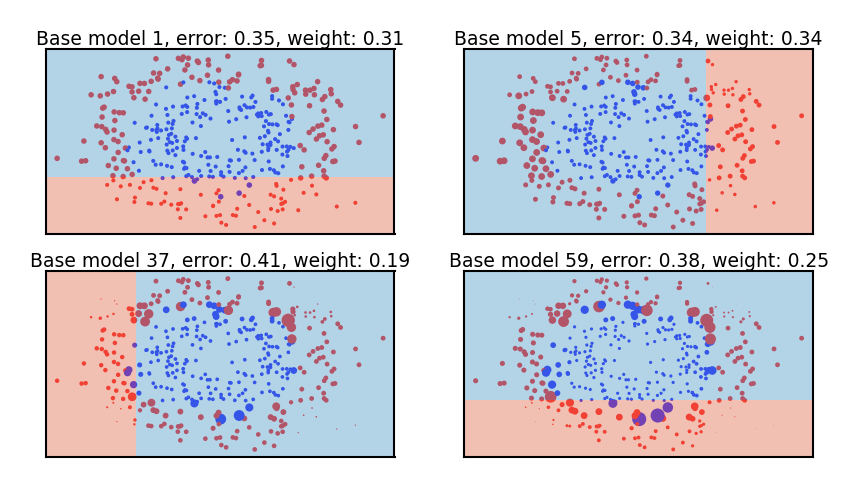

In [17]:
if not interactive:
    fig, axes = plt.subplots(2, 2, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(11*fig_scale, 6*fig_scale))
    weight_scale = 0.5
    for iteration, ax in zip([1, 5, 37, 59],axes.flatten()):
        current_ax = ax
        plot_adaboost(iteration)

### Examples

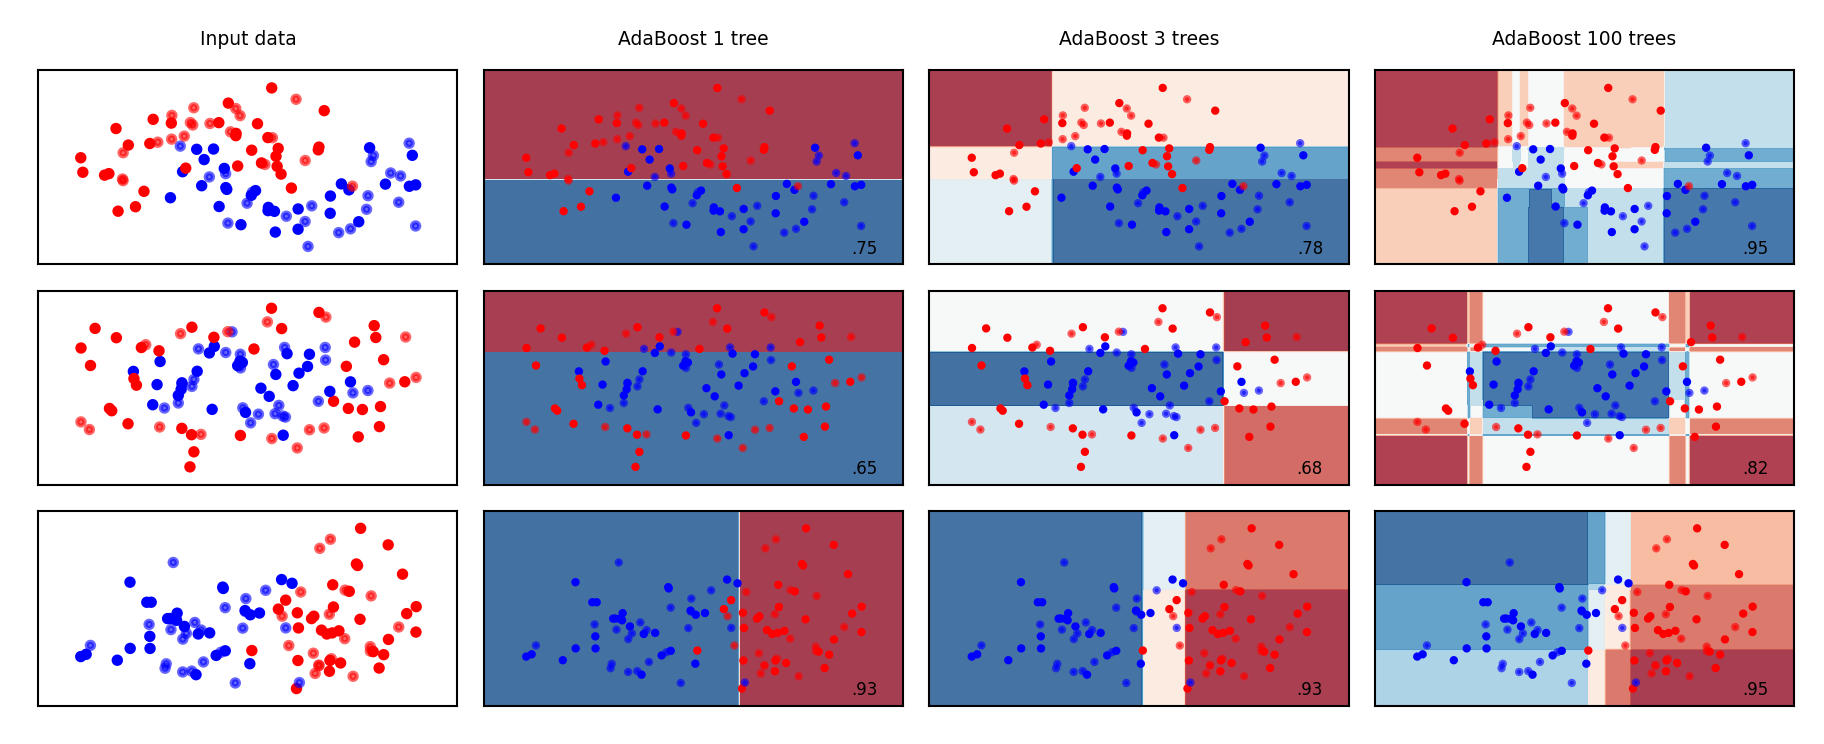

In [18]:
from sklearn.ensemble import AdaBoostClassifier
names = ["AdaBoost 1 tree", "AdaBoost 3 trees", "AdaBoost 100 trees"]

classifiers = [
    AdaBoostClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
    ]

mglearn.plots.plot_classifiers(names, classifiers, figuresize=(20*fig_scale,8*fig_scale))  

### Bias-Variance analysis
* AdaBoost reduces bias (and a little variance)
    * Boosting is a _bias reduction_ technique
* Boosting too much will eventually increase variance

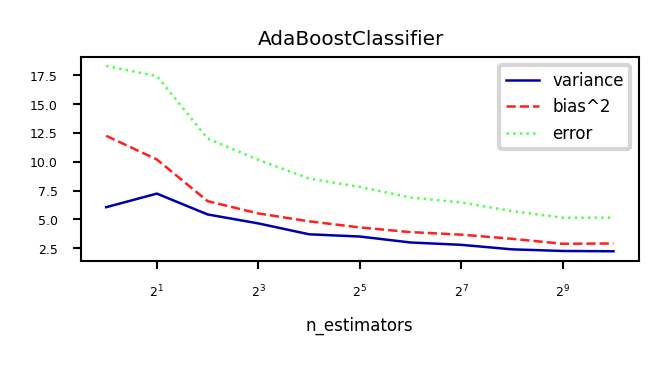

In [19]:
Xc, yc = cancer.data, cancer.target
ab = AdaBoostClassifier(random_state=0, n_estimators=1024)
plot_bias_variance_rf(ab, Xc, yc)

## Gradient Boosting
* Ensemble of models, each fixing the remaining mistakes of the previous ones
    * Each iteration, the task is to predict the _residual error_ of the ensemble
* Additive model: Predictions at iteration $I$ are sum of base model predictions
    * Learning rate (or _shrinkage_ ) $\eta$: small updates work better (reduces variance)
$$f_I(\mathbf{x}) = g_0(\mathbf{x}) + \sum_{i=1}^I \eta \cdot g_i(\mathbf{x}) = f_{I-1}(\mathbf{x}) + \eta \cdot g_I(\mathbf{x})$$
* The _pseudo-residuals_ $r_i$ are computed according to differentiable loss function
    * E.g. least squares loss for regression and log loss for classification
    * Gradient descent: _predictions_ get updated step by step until convergence
$$g_i(\mathbf{x}) \approx r_{i} = - \frac{\partial \mathcal{L}(y_i,f_{i-1}(x_i))}{\partial f_{i-1}(x_i)}$$
* Base models $g_i$ should be low variance, but flexible enough to predict residuals accurately
    * E.g. decision trees of depth 2-5

### Gradient Boosting Trees (Regression)

* Base models are regression trees, loss function is square loss: $\mathcal{L} = \frac{1}{2}(y_i - \hat{y}_i)^2$
* The pseudo-residuals are simply the prediction errors for every sample:
$$r_i = -\frac{\partial \mathcal{L}}{\partial \hat{y}} = -2 * \frac{1}{2}(y_i - \hat{y}_i) * (-1) =  y_i - \hat{y}_i$$
* Initial model $g_0$ simply predicts the mean of $y$
* For iteration $m=1..M$:
    * For all samples i=1..n, compute pseudo-residuals $r_i = y_i - \hat{y}_i$
    * Fit a new regression tree model $g_m(\mathbf{x})$ to $r_{i}$
        * In $g_m(\mathbf{x})$, each leaf predicts the mean of all its values
    * Update ensemble predictions $\hat{y} = g_0(\mathbf{x}) + \sum_{m=1}^M \eta \cdot g_m(\mathbf{x})$

* Early stopping (optional): stop when performance on validation set does not improve for $nr$ iterations


#### Gradient Boosting Regression in action
* Residuals quickly drop to (near) zero

In [20]:
# Example adapted from Andreas Mueller
from sklearn.ensemble import GradientBoostingRegressor

# Make some toy data
def make_poly(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (x) ** 3
    y = (y_no_noise + rnd.normal(scale=3, size=len(x))) / 2
    return x.reshape(-1, 1), y
Xp, yp = make_poly()

# Train gradient booster and get predictions
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, random_state=0)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=61, learning_rate=.3, random_state=0).fit(Xp_train, yp_train)
gbrt.score(Xp_test, yp_test)

line = np.linspace(Xp.min(), Xp.max(), 1000)
preds = list(gbrt.staged_predict(line[:, np.newaxis]))
preds_train = [np.zeros(len(yp_train))] + list(gbrt.staged_predict(Xp_train))

# Plot
def plot_gradient_boosting_step(step, axes):
    axes[0].plot(Xp_train[:, 0], yp_train - preds_train[step], 'o', alpha=0.5, markersize=10*fig_scale)
    axes[0].plot(line, gbrt.estimators_[step, 0].predict(line[:, np.newaxis]), linestyle='-', lw=3*fig_scale)
    axes[0].plot(line, [0]*len(line), c='k', linestyle='-', lw=1*fig_scale)
    axes[1].plot(Xp_train[:, 0], yp_train, 'o',  alpha=0.5, markersize=10*fig_scale)
    axes[1].plot(line, preds[step], linestyle='-', lw=3*fig_scale)
    axes[1].vlines(Xp_train[:, 0], yp_train, preds_train[step+1])

    axes[0].set_title("Residual prediction step {}".format(step + 1))
    axes[1].set_title("Total prediction step {}".format(step + 1))
    axes[0].set_ylim(yp.min(), yp.max())
    axes[1].set_ylim(yp.min(), yp.max())
    plt.tight_layout();

@interact
def plot_gradient_boosting(step = (0, 60, 1)):
    fig, axes = plt.subplots(1, 2, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(10*fig_scale, 4*fig_scale))
    plot_gradient_boosting_step(step, axes)


interactive(children=(IntSlider(value=30, description='step', max=60), Output()), _dom_classes=('widget-intera…

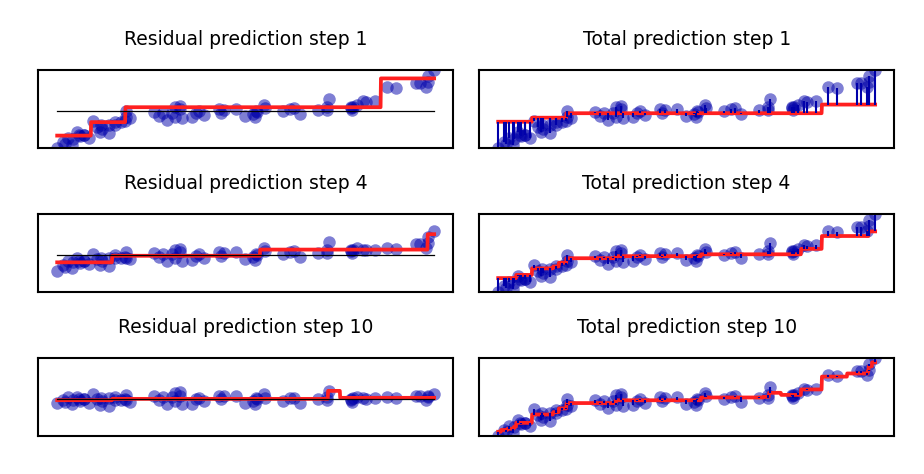

In [21]:
if not interactive:
    fig, all_axes = plt.subplots(3, 2, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(10*fig_scale, 5*fig_scale))
    for i, s in enumerate([0,3,9]):
        axes = all_axes[i,:]
        plot_gradient_boosting_step(s, axes)

### GradientBoosting Algorithm (Classification)

* Base models are _regression_ trees, predict probability of positive class $p$
    * For multi-class problems, train one tree per class
* Use (binary) log loss, with true class $y_i \in {0,1}$: $\mathcal{L_{log}} = - \sum_{i=1}^{N} \big[ y_i log(p_i) + (1-y_i) log(1-p_i) \big] $
* The pseudo-residuals are simply the difference between true class and predicted $p$:
$$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{\partial \mathcal{L}}{\partial log(p_i)} = y_i - p_i$$
* Initial model $g_0$ predicts $p = log(\frac{\#positives}{\#negatives})$ 
* For iteration $m=1..M$:
    * For all samples i=1..n, compute pseudo-residuals $r_i = y_i - p_i$
    * Fit a new regression tree model $g_m(\mathbf{x})$ to $r_{i}$
        * In $g_m(\mathbf{x})$, each leaf predicts $\frac{\sum_{i} r_i}{\sum_{i} p_i(1-p_i)}$
    * Update ensemble predictions $\hat{y} = g_0(\mathbf{x}) + \sum_{m=1}^M \eta \cdot g_m(\mathbf{x})$
* Early stopping (optional): stop when performance on validation set does not improve for $nr$ iterations

#### Gradient Boosting Classification in action
* Size of the samples represents the residual weights: most quickly drop to (near) zero

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, random_state=0)
gbct = GradientBoostingClassifier(max_depth=2, n_estimators=60, learning_rate=.3, random_state=0).fit(Xa_train, ya_train)
gbct.score(Xa_test, ya_test)
preds_train_cl = [np.zeros(len(ya_train))] + list(gbct.staged_predict_proba(Xa_train))
current_gb_ax = None
weight_scale = 1

def plot_gb_decision_boundary(gbmodel, step, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None, title = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40, edgecolors='none')
    ax.set_xticks(())
    ax.set_yticks(())
    if title:
        ax.set_title(title, pad='0.5')
    
    # Plot classifier background
    if gbmodel is not None:
        xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
        zz = np.array( [list(gbmodel.staged_predict_proba(np.array([xi,yi]).reshape(1,-1)))[step][:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        Z = zz.reshape(xx.shape)
        ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5, levels=[0,0.5,1])


@interact
def plot_gboost(iteration=(1,60,1)):
    pseudo_residuals = np.abs(ya_train - preds_train_cl[iteration][:,1])
    title = "Base model {}, error: {:.2f}".format(iteration,np.sum(pseudo_residuals))
    plot_gb_decision_boundary(gbct, (iteration-1), Xa_train, ya_train, N = 20, scatter_weights =pseudo_residuals * weight_scale, ax=current_gb_ax, title=title ) 
        

interactive(children=(IntSlider(value=30, description='iteration', max=60, min=1), Output()), _dom_classes=('w…

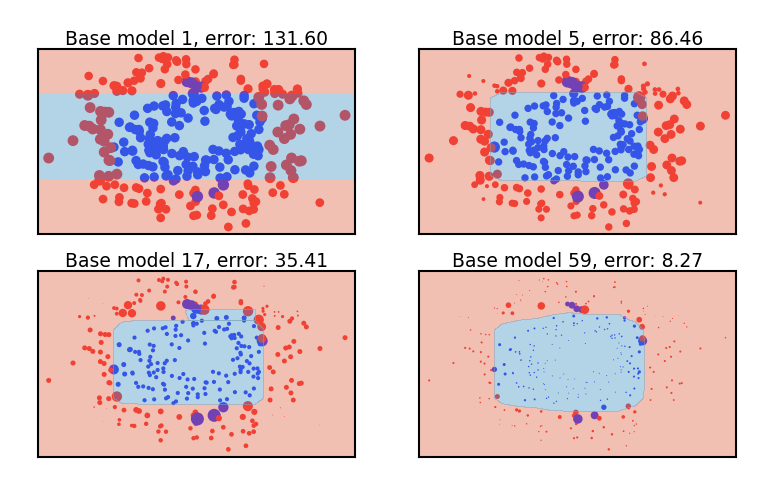

In [23]:
if not interactive:
    fig, axes = plt.subplots(2, 2, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(10*fig_scale, 6*fig_scale))
    weight_scale = 0.3
    for iteration, ax in zip([1, 5, 17, 59],axes.flatten()):
        current_gb_ax = ax
        plot_gboost(iteration)

#### Examples

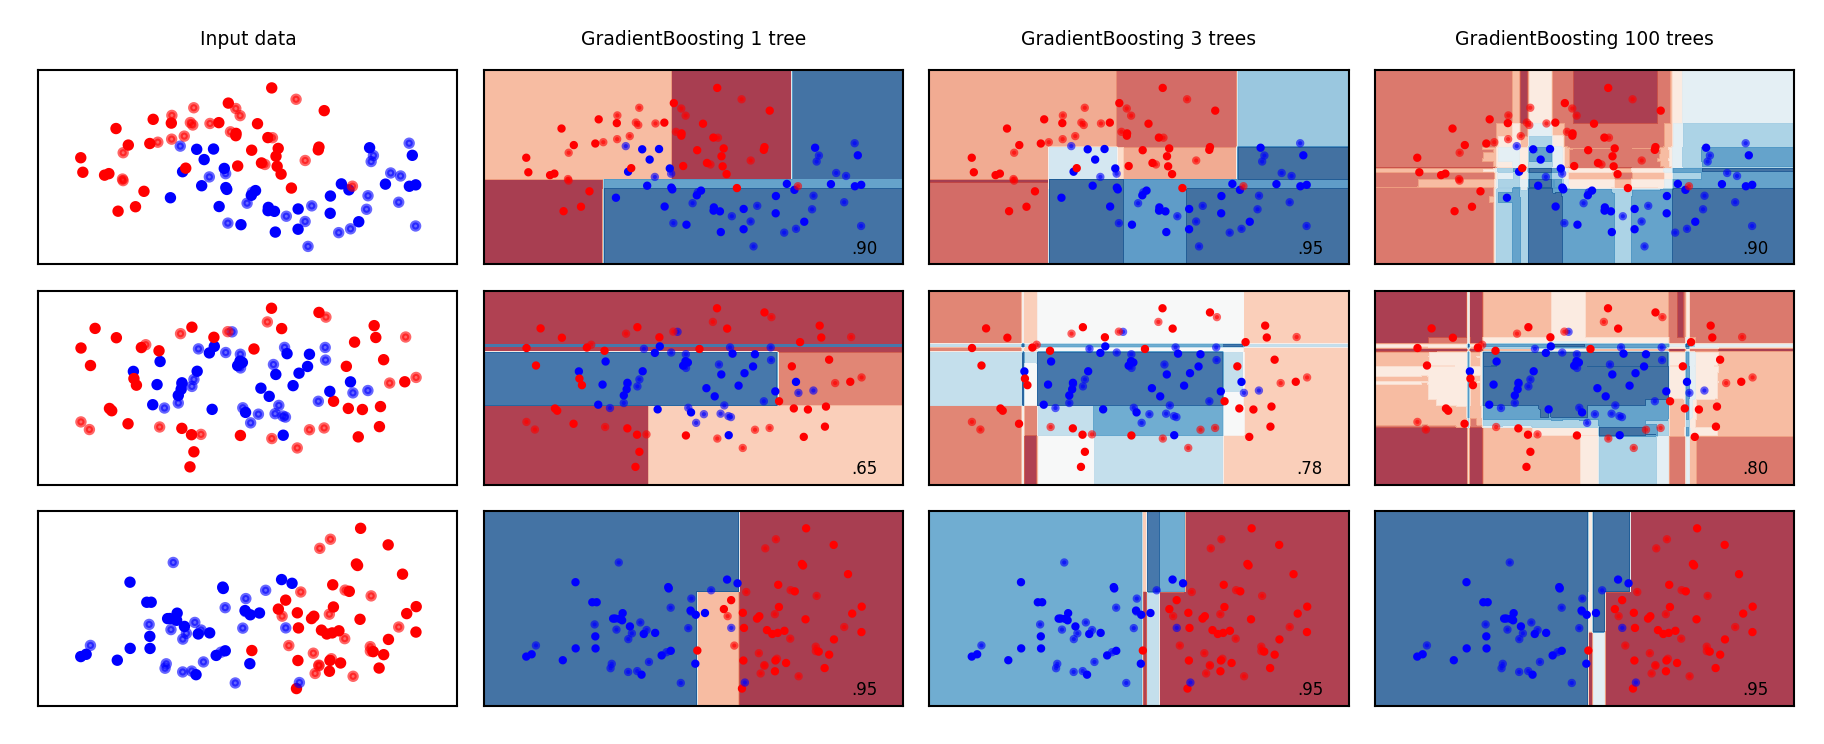

In [24]:
names = ["GradientBoosting 1 tree", "GradientBoosting 3 trees", "GradientBoosting 100 trees"]

classifiers = [
    GradientBoostingClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
    ]

mglearn.plots.plot_classifiers(names, classifiers, figuresize=(20*fig_scale,8*fig_scale))  

#### Bias-variance analysis
* Gradient Boosting is very effective at reducing bias error
* Boosting too much will eventually increase variance

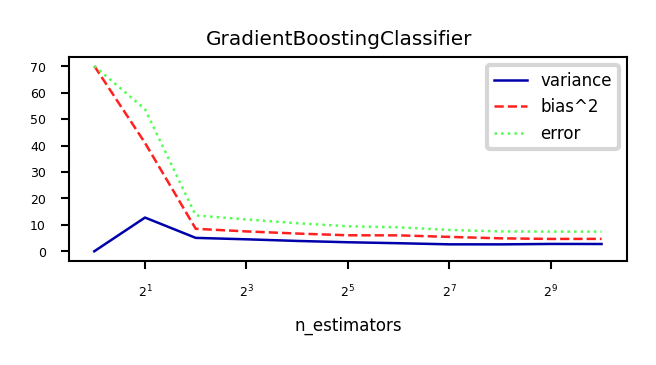

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Tried if HistGradientBoostingClassifier is faster. It's not.
# We're training many small models here and the thread spawning likely causes too much overhead
# gb = HistGradientBoostingClassifier(random_state=0, max_iter=512)
gb = GradientBoostingClassifier(random_state=0, n_estimators=512)
plot_bias_variance_rf(gb, Xc, yc)

#### Feature importance
* Gradient Boosting also provide feature importances, based on many trees
* Compared to RandomForests, the trees are smaller, hence more features have zero importance

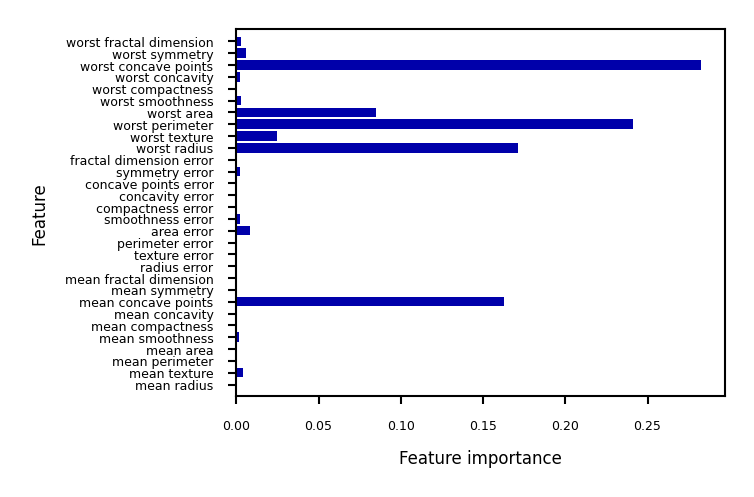

In [26]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(Xc_train, yc_train)
plot_feature_importances_cancer(gbrt)

#### Gradient Boosting: strengths and weaknesses
* Among the most powerful and widely used models
* Work well on heterogeneous features and different scales
* Typically better than random forests, but requires more tuning, longer training
* Does not work well on high-dimensional sparse data

Main hyperparameters:

* `n_estimators`: Higher is better, but will start to overfit
* `learning_rate`: Lower rates mean more trees are needed to get more complex models
    * Set `n_estimators` as high as possible, then tune `learning_rate`
    * Or, choose a `learning_rate` and use early stopping to avoid overfitting
* `max_depth`: typically kept low (<5), reduce when overfitting
* `max_features`: can also be tuned, similar to random forests
* `n_iter_no_change`: early stopping: algorithm stops if improvement is less than a certain tolerance `tol` for more than `n_iter_no_change` iterations.

### Extreme Gradient Boosting (XGBoost)

- Faster version of gradient boosting: allows more iterations on larger datasets
- Normal regression trees: split to minimize squared loss of leaf predictions
    - XGBoost trees only fit residuals: split so that residuals in leaf are more _similar_
- Don't evaluate every split point, only $q$ _quantiles_ per feature (binning)
    - $q$ is hyperparameter (`sketch_eps`, default 0.03)
- For large datasets, XGBoost uses _approximate quantiles_
    - Can be parallelized (multicore) by chunking the data and combining histograms of data
    - For classification, the quantiles are weighted by $p(1-p)$
- Gradient descent sped up by using the second derivative of the loss function
- Strong regularization by pre-pruning the trees
- Column and row are randomly subsampled when computing splits
- Support for out-of-core computation (data compression in RAM, sharding,...)

#### XGBoost in practice
* Not part of scikit-learn, but `HistGradientBoostingClassifier` is similar
    * binning, multicore,...
* The `xgboost` python package is sklearn-compatible
    * Install separately, `conda install -c conda-forge xgboost`
    * Allows learning curve plotting and warm-starting
* Further reading:
    * [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)
    * [Paper](http://arxiv.org/abs/1603.02754)  
    * [Video](https://www.youtube.com/watch?v=oRrKeUCEbq8)

### LightGBM
Another fast boosting technique

* Uses _gradient-based sampling_
    - use all instances with large gradients/residuals (e.g. 10% largest) 
    - randomly sample instances with small gradients, ignore the rest
    - intuition: samples with small gradients are already well-trained.
    - requires adapted information gain criterion
* Does smarter encoding of categorical features

### CatBoost
Another fast boosting technique

* Optimized for categorical variables
    * Uses bagged and smoothed version of target encoding
* Uses symmetric trees: same split for all nodes on a given level aka 
    * Can be much faster
* Allows monotonicity constraints for numeric features
    * Model must be be a non-decreasing function of these features
* Lots of tooling (e.g. GPU training)

## Stacking

- Choose $M$ different base-models, generate predictions
- Stacker (meta-model) learns mapping between predictions and correct label
    - Can also be repeated: multi-level stacking
    - Popular stackers: linear models (fast) and gradient boosting (accurate)
- Cascade stacking: adds base-model predictions as extra features
- Models need to be sufficiently different, be experts at different parts of the data
- Can be _very_ accurate, but also very slow to predict
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/stacking.png" alt="ml" style="width: 500px;"/>

## Other ensembling techniques

- Hyper-ensembles: same basic model but with different hyperparameter settings
    - Can combine overfitted and underfitted models
- Deep ensembles: ensembles of deep learning models
- Bayes optimal classifier: ensemble of all possible models (largely theoretic)
- Bayesian model averaging: weighted average of probabilistic models, weighted by their posterior probabilities
- Cross-validation selection: does internal cross-validation to select best of $M$ models
- Any combination of different ensembling techniques

In [27]:
%%HTML
<style>
td {font-size: 20px}
th {font-size: 20px}
.rendered_html table, .rendered_html td, .rendered_html th {
    font-size: 20px;
}
</style>

### Algorithm overview

| Name | Representation | Loss function | Optimization | Regularization |
|---|---|---|---|---|
| Classification trees | Decision tree | Entropy / Gini index | Hunt's algorithm | Tree depth,... |
| Regression trees | Decision tree | Square loss | Hunt's algorithm | Tree depth,... |
| RandomForest | Ensemble of randomized trees | Entropy / Gini / Square | (Bagging) |  Number/depth of trees,... |
| AdaBoost | Ensemble of stumps | Exponential loss | Greedy search |  Number/depth of trees,... |
| GradientBoostingRegression | Ensemble of regression trees | Square loss | Gradient descent |  Number/depth of trees,... |
| GradientBoostingClassification | Ensemble of regression trees | Log loss | Gradient descent |  Number/depth of trees,... |
| XGBoost, LightGBM, CatBoost | Ensemble of XGBoost trees | Square/log loss | 2nd order gradients |  Number/depth of trees,... |
| Stacking | Ensemble of heterogeneous models | / | / |  Number of models,... |

### Summary
- Ensembles of voting classifiers improve performance
    - Which models to choose? Consider bias-variance tradeoffs!
- Bagging / RandomForest is a variance-reduction technique
    - Build many high-variance (overfitting) models on random data samples
        - The more different the models, the better
    - Aggregation (soft voting) over many models reduces variance
        - Diminishing returns, over-smoothing may increase bias error
    - Parallellizes easily, doesn't require much tuning
- Boosting is a bias-reduction technique
    - Build low-variance models that correct each other's mistakes
        - By reweighting misclassified samples: AdaBoost
        - By predicting the residual error: Gradient Boosting
    - Additive models: predictions are sum of base-model predictions
        - Can drive the error to zero, but risk overfitting
    - Doesn't parallelize easily. Slower to train, much faster to predict.
        - XGBoost,LightGBM,... are fast and offer some parallellization
- Stacking: learn how to combine base-model predictions
    - Base-models still have to be sufficiently different